## 📚 Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    precision_score, recall_score, f1_score
)
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 📊 Step 2: Load and Explore Data

In [2]:
# Load data
df = pd.read_csv('datasets/cattle_treatment_dataset.csv')

print("Dataset Shape:", df.shape)
print("\nFirst 10 rows:")
print(df.head(10))
print("\nDataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (2000, 9)

First 10 rows:
           Disease  Severity  Weight  Age Breed  Temperature Previous_Disease  \
0      Pediculosis         1   386.7   83   AFS         39.5              NaN   
1              FMD         1   416.7   35   AFS         39.5              NaN   
2         Mastitis         0   386.4   32   AFS         38.8              NaN   
3       Contagious         0   472.4   53   AFS         38.5         Ringworm   
4         Mastitis         1   389.9   66   AFS         39.8              NaN   
5      Pediculosis         0   363.0   15   AFS         39.0              NaN   
6  Dermatophilosis         0   486.8   71   AFS         38.6              NaN   
7         Mastitis         0   386.4   15   AFS         38.7              NaN   
8         Mastitis         0   518.5   55   AFS         39.0         Mastitis   
9         Ringworm         0   464.1   73   AFS         38.7              NaN   

                        Treatment  Feed_Adjustment_Percent  
0     

In [3]:
# Treatment distribution
print("\n💊 Treatment Distribution:")
treatment_counts = df['Treatment'].value_counts()
print(treatment_counts)
print(f"\n✅ Total samples: {len(df)}")
print(f"✅ Number of treatment types: {df['Treatment'].nunique()}")
print(f"\n📋 All treatments:")
for i, treatment in enumerate(df['Treatment'].unique(), 1):
    count = len(df[df['Treatment']==treatment])
    print(f"  {i}. {treatment}: {count} cases ({count/len(df)*100:.1f}%)")


💊 Treatment Distribution:
Treatment
Antibiotics + Isolation           672
Topical Treatment + Monitoring    391
Antiparasitic + Monitoring        244
No Treatment Required             239
Anti-inflammatory + Rest          218
Antiviral + Quarantine            111
Supportive Care Only               83
Antifungal + Topical Care          42
Name: count, dtype: int64

✅ Total samples: 2000
✅ Number of treatment types: 8

📋 All treatments:
  1. Antiparasitic + Monitoring: 244 cases (12.2%)
  2. Antibiotics + Isolation: 672 cases (33.6%)
  3. Anti-inflammatory + Rest: 218 cases (10.9%)
  4. Topical Treatment + Monitoring: 391 cases (19.6%)
  5. No Treatment Required: 239 cases (11.9%)
  6. Antifungal + Topical Care: 42 cases (2.1%)
  7. Antiviral + Quarantine: 111 cases (5.5%)
  8. Supportive Care Only: 83 cases (4.2%)


In [4]:
# Check unique values in all columns
print("\n📋 Column Summary:")
print(f"\nDiseases ({df['Disease'].nunique()}): {df['Disease'].unique()}")
print(f"\nSeverity levels: {sorted(df['Severity'].unique())}")
print(f"\nPrevious Diseases ({df['Previous_Disease'].nunique()}): {df['Previous_Disease'].unique()}")


📋 Column Summary:

Diseases (8): ['Pediculosis' 'FMD' 'Mastitis' 'Contagious' 'Dermatophilosis' 'Ringworm'
 'Lumpy Skin' 'Healthy']

Severity levels: [np.int64(0), np.int64(1), np.int64(2)]

Previous Diseases (7): [nan 'Ringworm' 'Mastitis' 'Contagious' 'Pediculosis' 'Dermatophilosis'
 'Lumpy Skin' 'FMD']


## 📈 Step 3: Exploratory Data Analysis (EDA)

In [5]:
# Create output directory
import os
os.makedirs('models/Treatment_Recommendation', exist_ok=True)
print("✅ Output directory created: models/Treatment_Recommendation/")

✅ Output directory created: models/Treatment_Recommendation/


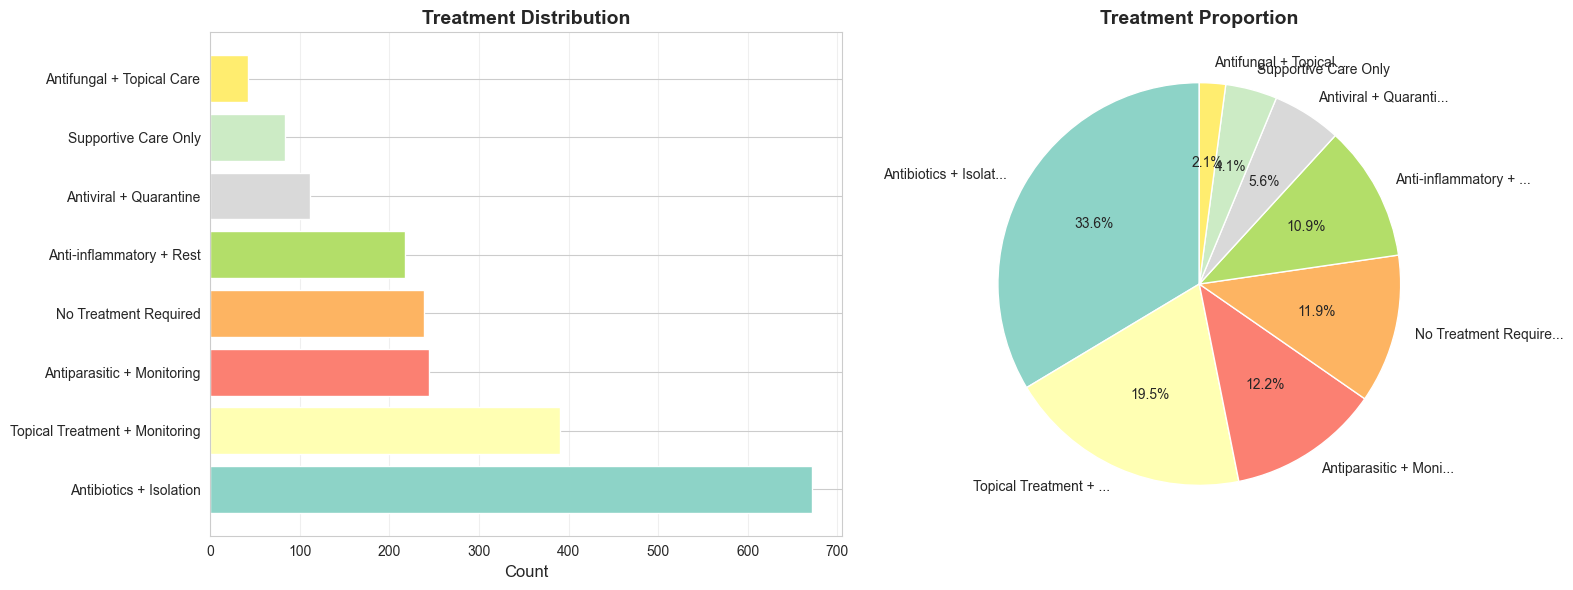

In [7]:
# Treatment distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
treatment_counts = df['Treatment'].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(treatment_counts)))
axes[0].barh(range(len(treatment_counts)), treatment_counts.values, color=colors)
axes[0].set_yticks(range(len(treatment_counts)))
axes[0].set_yticklabels([t[:30] + '...' if len(t) > 30 else t for t in treatment_counts.index])
axes[0].set_xlabel('Count', fontsize=12)
axes[0].set_title('Treatment Distribution', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Pie chart
axes[1].pie(treatment_counts.values, labels=[t[:20] + '...' if len(t) > 20 else t for t in treatment_counts.index], 
            autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Treatment Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('models/Treatment_Recommendation/treatment_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

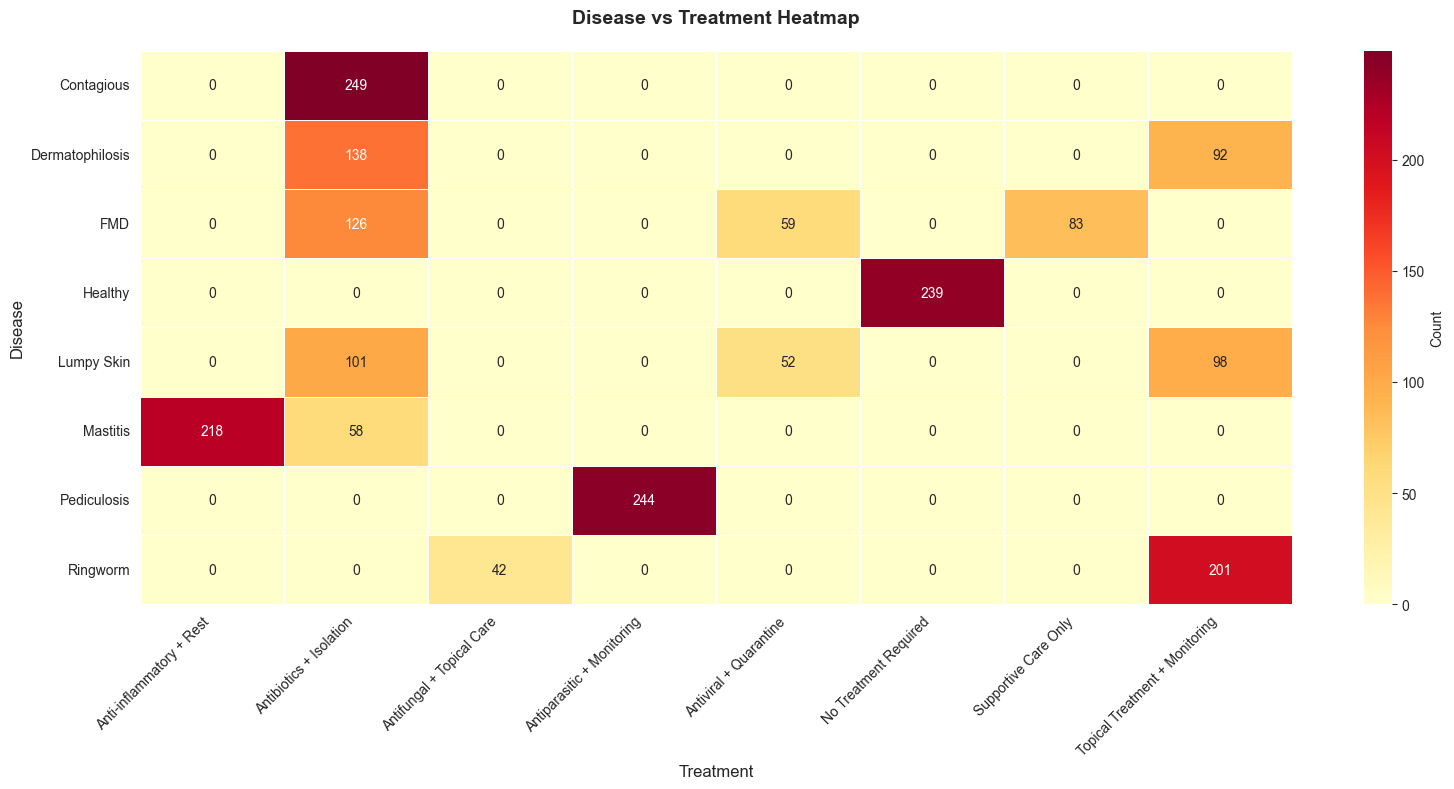


📊 Disease vs Treatment Crosstab:
Treatment        Anti-inflammatory + Rest  Antibiotics + Isolation  \
Disease                                                              
Contagious                              0                      249   
Dermatophilosis                         0                      138   
FMD                                     0                      126   
Healthy                                 0                        0   
Lumpy Skin                              0                      101   
Mastitis                              218                       58   
Pediculosis                             0                        0   
Ringworm                                0                        0   

Treatment        Antifungal + Topical Care  Antiparasitic + Monitoring  \
Disease                                                                  
Contagious                               0                           0   
Dermatophilosis                          0 

In [8]:
# Disease vs Treatment heatmap
disease_treatment = pd.crosstab(df['Disease'], df['Treatment'])

plt.figure(figsize=(16, 8))
sns.heatmap(disease_treatment, annot=True, fmt='d', cmap='YlOrRd', 
            cbar_kws={'label': 'Count'}, linewidths=0.5)
plt.title('Disease vs Treatment Heatmap', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Treatment', fontsize=12)
plt.ylabel('Disease', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('models/Treatment_Recommendation/disease_treatment_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Disease vs Treatment Crosstab:")
print(disease_treatment)

<Figure size 1600x600 with 0 Axes>

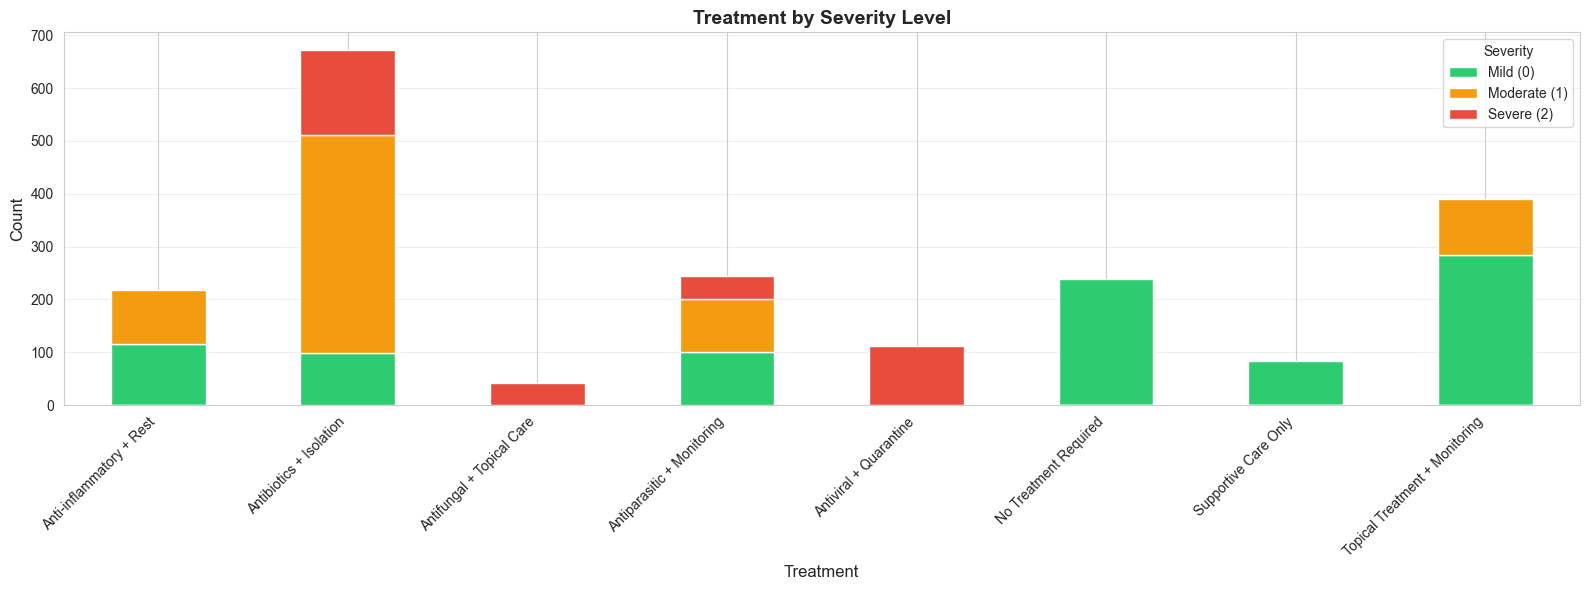


📊 Severity vs Treatment Crosstab:
Treatment  Anti-inflammatory + Rest  Antibiotics + Isolation  \
Severity                                                       
0                               115                       98   
1                               103                      413   
2                                 0                      161   

Treatment  Antifungal + Topical Care  Antiparasitic + Monitoring  \
Severity                                                           
0                                  0                         100   
1                                  0                         100   
2                                 42                          44   

Treatment  Antiviral + Quarantine  No Treatment Required  \
Severity                                                   
0                               0                    239   
1                               0                      0   
2                             111                      0   

Tr

In [9]:
# Severity vs Treatment
severity_treatment = pd.crosstab(df['Severity'], df['Treatment'])

plt.figure(figsize=(16, 6))
severity_treatment.T.plot(kind='bar', stacked=True, color=['#2ecc71', '#f39c12', '#e74c3c'], figsize=(16, 6))
plt.title('Treatment by Severity Level', fontsize=14, fontweight='bold')
plt.xlabel('Treatment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Severity', labels=['Mild (0)', 'Moderate (1)', 'Severe (2)'])
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('models/Treatment_Recommendation/severity_treatment_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Severity vs Treatment Crosstab:")
print(severity_treatment)

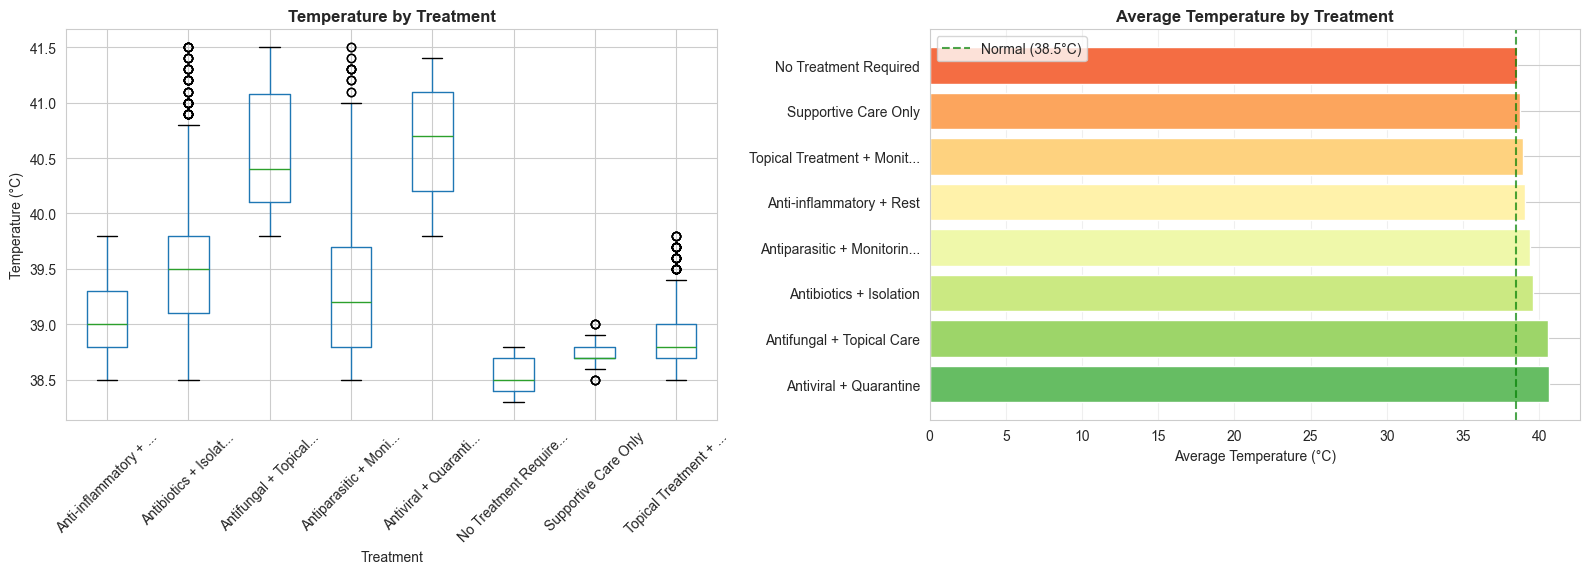

In [10]:
# Treatment by temperature and severity
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Temperature by treatment (box plot)
treatment_short = [t[:20] + '...' if len(t) > 20 else t for t in df['Treatment']]
df_temp = df.copy()
df_temp['Treatment_Short'] = treatment_short

df_temp.boxplot(column='Temperature', by='Treatment_Short', ax=axes[0], rot=45)
axes[0].set_title('Temperature by Treatment', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Treatment', fontsize=10)
axes[0].set_ylabel('Temperature (°C)', fontsize=10)
plt.sca(axes[0])
plt.suptitle('')

# Average temperature by treatment (bar plot)
temp_by_treatment = df.groupby('Treatment')['Temperature'].mean().sort_values(ascending=False)
colors_temp = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(temp_by_treatment)))
axes[1].barh(range(len(temp_by_treatment)), temp_by_treatment.values, color=colors_temp)
axes[1].set_yticks(range(len(temp_by_treatment)))
axes[1].set_yticklabels([t[:25] + '...' if len(t) > 25 else t for t in temp_by_treatment.index])
axes[1].set_xlabel('Average Temperature (°C)', fontsize=10)
axes[1].set_title('Average Temperature by Treatment', fontsize=12, fontweight='bold')
axes[1].axvline(x=38.5, color='green', linestyle='--', alpha=0.7, label='Normal (38.5°C)')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('models/Treatment_Recommendation/temperature_treatment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 🔧 Step 4: Feature Engineering & Preprocessing

In [11]:
# Select features for modeling
feature_columns = ['Disease', 'Severity', 'Weight', 'Age', 'Temperature', 'Previous_Disease']
target_column = 'Treatment'

# Create feature matrix and target
X = df[feature_columns].copy()
y = df[target_column].copy()

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {feature_columns}")
print(f"\nTarget distribution:")
print(y.value_counts())

Features shape: (2000, 6)
Target shape: (2000,)

Feature columns: ['Disease', 'Severity', 'Weight', 'Age', 'Temperature', 'Previous_Disease']

Target distribution:
Treatment
Antibiotics + Isolation           672
Topical Treatment + Monitoring    391
Antiparasitic + Monitoring        244
No Treatment Required             239
Anti-inflammatory + Rest          218
Antiviral + Quarantine            111
Supportive Care Only               83
Antifungal + Topical Care          42
Name: count, dtype: int64


In [12]:
# Encode categorical variables
label_encoders = {}

# Encode Disease
le_disease = LabelEncoder()
X['Disease_Encoded'] = le_disease.fit_transform(X['Disease'])
label_encoders['Disease'] = le_disease

# Encode Previous_Disease
le_prev_disease = LabelEncoder()
X['Previous_Disease_Encoded'] = le_prev_disease.fit_transform(X['Previous_Disease'])
label_encoders['Previous_Disease'] = le_prev_disease

# Encode Treatment (target)
le_treatment = LabelEncoder()
y_encoded = le_treatment.fit_transform(y)
label_encoders['Treatment'] = le_treatment

print("\n✅ Categorical variables encoded:")
print(f"  Disease: {len(le_disease.classes_)} categories")
print(f"    {list(le_disease.classes_)}")
print(f"  Previous_Disease: {len(le_prev_disease.classes_)} categories")
print(f"    {list(le_prev_disease.classes_)}")
print(f"  Treatment: {len(le_treatment.classes_)} categories")
for i, treatment in enumerate(le_treatment.classes_):
    print(f"    {i}: {treatment}")

# Drop original categorical columns and use encoded ones
X_processed = X[['Disease_Encoded', 'Severity', 'Weight', 'Age', 'Temperature', 'Previous_Disease_Encoded']].copy()

print(f"\n✅ Processed features shape: {X_processed.shape}")
print(f"\nFinal feature names: {list(X_processed.columns)}")


✅ Categorical variables encoded:
  Disease: 8 categories
    ['Contagious', 'Dermatophilosis', 'FMD', 'Healthy', 'Lumpy Skin', 'Mastitis', 'Pediculosis', 'Ringworm']
  Previous_Disease: 8 categories
    ['Contagious', 'Dermatophilosis', 'FMD', 'Lumpy Skin', 'Mastitis', 'Pediculosis', 'Ringworm', nan]
  Treatment: 8 categories
    0: Anti-inflammatory + Rest
    1: Antibiotics + Isolation
    2: Antifungal + Topical Care
    3: Antiparasitic + Monitoring
    4: Antiviral + Quarantine
    5: No Treatment Required
    6: Supportive Care Only
    7: Topical Treatment + Monitoring

✅ Processed features shape: (2000, 6)

Final feature names: ['Disease_Encoded', 'Severity', 'Weight', 'Age', 'Temperature', 'Previous_Disease_Encoded']


In [13]:
# Create additional engineered features
X_processed['Temp_Deviation'] = X_processed['Temperature'] - 38.5  # Normal cow temp is ~38.5°C
X_processed['Weight_Age_Ratio'] = X_processed['Weight'] / (X_processed['Age'] + 1)
X_processed['Has_History'] = (X_processed['Previous_Disease_Encoded'] > 0).astype(int)
X_processed['Severity_Temp_Interaction'] = X_processed['Severity'] * X_processed['Temp_Deviation']

print("\n✅ Created engineered features:")
print("  - Temp_Deviation (deviation from normal 38.5°C)")
print("  - Weight_Age_Ratio (growth indicator)")
print("  - Has_History (binary flag for disease history)")
print("  - Severity_Temp_Interaction (severity × temperature deviation)")
print(f"\nFinal feature count: {X_processed.shape[1]}")


✅ Created engineered features:
  - Temp_Deviation (deviation from normal 38.5°C)
  - Weight_Age_Ratio (growth indicator)
  - Has_History (binary flag for disease history)
  - Severity_Temp_Interaction (severity × temperature deviation)

Final feature count: 10


In [14]:
# Split data (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining set distribution:")
train_dist = pd.Series(y_train).value_counts().sort_index()
for idx, count in train_dist.items():
    print(f"  {le_treatment.classes_[idx]}: {count}")
print(f"\nTest set distribution:")
test_dist = pd.Series(y_test).value_counts().sort_index()
for idx, count in test_dist.items():
    print(f"  {le_treatment.classes_[idx]}: {count}")

Training set: 1600 samples
Test set: 400 samples

Training set distribution:
  Anti-inflammatory + Rest: 174
  Antibiotics + Isolation: 538
  Antifungal + Topical Care: 34
  Antiparasitic + Monitoring: 195
  Antiviral + Quarantine: 89
  No Treatment Required: 191
  Supportive Care Only: 66
  Topical Treatment + Monitoring: 313

Test set distribution:
  Anti-inflammatory + Rest: 44
  Antibiotics + Isolation: 134
  Antifungal + Topical Care: 8
  Antiparasitic + Monitoring: 49
  Antiviral + Quarantine: 22
  No Treatment Required: 48
  Supportive Care Only: 17
  Topical Treatment + Monitoring: 78


In [15]:
# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features standardized (mean=0, std=1)")
print(f"\nTraining set - Mean: {X_train_scaled.mean():.4f}, Std: {X_train_scaled.std():.4f}")
print(f"Test set - Mean: {X_test_scaled.mean():.4f}, Std: {X_test_scaled.std():.4f}")

✅ Features standardized (mean=0, std=1)

Training set - Mean: -0.0000, Std: 1.0000
Test set - Mean: -0.0414, Std: 0.9953


## 🤖 Step 5: Train Multiple Models

In [16]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000, multi_class='multinomial', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=300, max_depth=20, min_samples_split=5, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_depth=10, random_state=42),
    'SVM': SVC(kernel='rbf', C=10, probability=True, random_state=42)
}

print("🚀 Training models...\n")
print("⏳ Note: Training may take a few minutes due to 9-class problem\n")

# Store results
results = {}
trained_models = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # Cross-validation (3-fold to save time)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=3, scoring='accuracy')
    
    # Store results
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred
    }
    
    trained_models[name] = model
    
    print(f"  ✅ Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
    print(f"  ✅ CV Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})\n")

print("✅ All models trained!")

🚀 Training models...

⏳ Note: Training may take a few minutes due to 9-class problem

Training Logistic Regression...
  ✅ Accuracy: 0.5675 | Precision: 0.5999 | Recall: 0.5675 | F1: 0.5422
  ✅ CV Score: 0.5706 (±0.0166)

Training Random Forest...
  ✅ Accuracy: 0.9850 | Precision: 0.9852 | Recall: 0.9850 | F1: 0.9846
  ✅ CV Score: 0.9931 (±0.0054)

Training Gradient Boosting...
  ✅ Accuracy: 0.9950 | Precision: 0.9951 | Recall: 0.9950 | F1: 0.9949
  ✅ CV Score: 0.9950 (±0.0071)

Training SVM...
  ✅ Accuracy: 0.9475 | Precision: 0.9492 | Recall: 0.9475 | F1: 0.9473
  ✅ CV Score: 0.8713 (±0.0217)

✅ All models trained!


## 📊 Step 6: Compare Model Performance

In [17]:
# Create comparison dataframe
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df[['accuracy', 'precision', 'recall', 'f1_score', 'cv_mean', 'cv_std']]
comparison_df = comparison_df.round(4)

print("\n📊 Model Performance Comparison:\n")
print(comparison_df)

# Find best model
best_model_name = comparison_df['accuracy'].idxmax()
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Accuracy: {comparison_df.loc[best_model_name, 'accuracy']:.4f}")
print(f"   F1-Score: {comparison_df.loc[best_model_name, 'f1_score']:.4f}")
print(f"   CV Score: {comparison_df.loc[best_model_name, 'cv_mean']:.4f}")


📊 Model Performance Comparison:

                    accuracy precision  recall  f1_score   cv_mean    cv_std
Logistic Regression   0.5675  0.599859  0.5675  0.542199  0.570611  0.016565
Random Forest          0.985  0.985199   0.985  0.984574  0.993121   0.00538
Gradient Boosting      0.995  0.995074   0.995  0.994899  0.994997  0.007075
SVM                   0.9475  0.949168  0.9475  0.947314  0.871269   0.02165

🏆 Best Model: Gradient Boosting
   Accuracy: 0.9950
   F1-Score: 0.9949
   CV Score: 0.9950


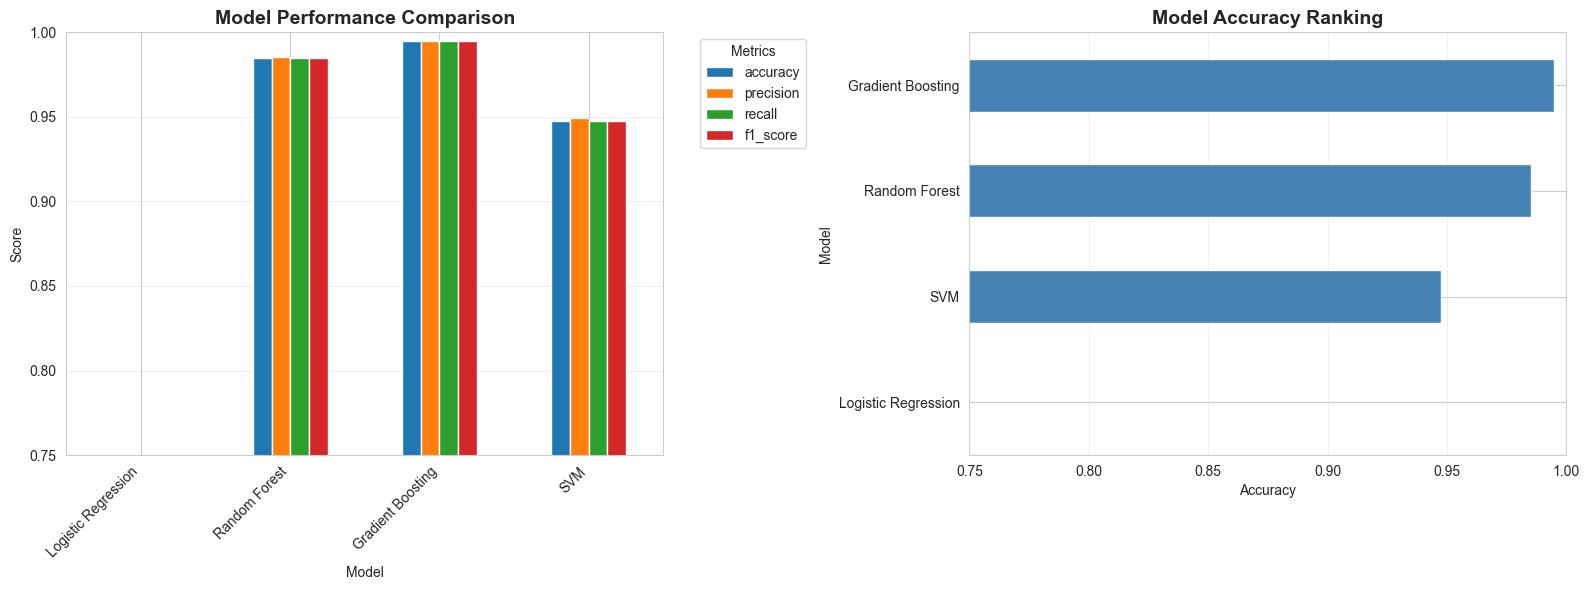

In [18]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Metrics comparison
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
comparison_df[metrics_to_plot].plot(kind='bar', ax=axes[0])
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Score')
axes[0].legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_ylim([0.75, 1.0])
axes[0].grid(axis='y', alpha=0.3)

# Accuracy ranking
comparison_df['accuracy'].sort_values(ascending=True).plot(kind='barh', ax=axes[1], color='steelblue')
axes[1].set_title('Model Accuracy Ranking', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Accuracy')
axes[1].set_ylabel('Model')
axes[1].set_xlim([0.75, 1.0])
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('models/Treatment_Recommendation/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 📈 Step 7: Detailed Evaluation of Best Model

In [19]:
# Get best model
best_model = trained_models[best_model_name]
best_predictions = results[best_model_name]['predictions']

# Classification report
print(f"\n📊 Detailed Classification Report - {best_model_name}\n")
treatment_labels = [t[:30] + '...' if len(t) > 30 else t for t in le_treatment.classes_]
print(classification_report(y_test, best_predictions, target_names=treatment_labels, zero_division=0))


📊 Detailed Classification Report - Gradient Boosting

                                precision    recall  f1-score   support

      Anti-inflammatory + Rest       1.00      1.00      1.00        44
       Antibiotics + Isolation       0.99      1.00      0.99       134
     Antifungal + Topical Care       1.00      1.00      1.00         8
    Antiparasitic + Monitoring       1.00      1.00      1.00        49
        Antiviral + Quarantine       1.00      0.91      0.95        22
         No Treatment Required       1.00      1.00      1.00        48
          Supportive Care Only       1.00      1.00      1.00        17
Topical Treatment + Monitoring       1.00      1.00      1.00        78

                      accuracy                           0.99       400
                     macro avg       1.00      0.99      0.99       400
                  weighted avg       1.00      0.99      0.99       400



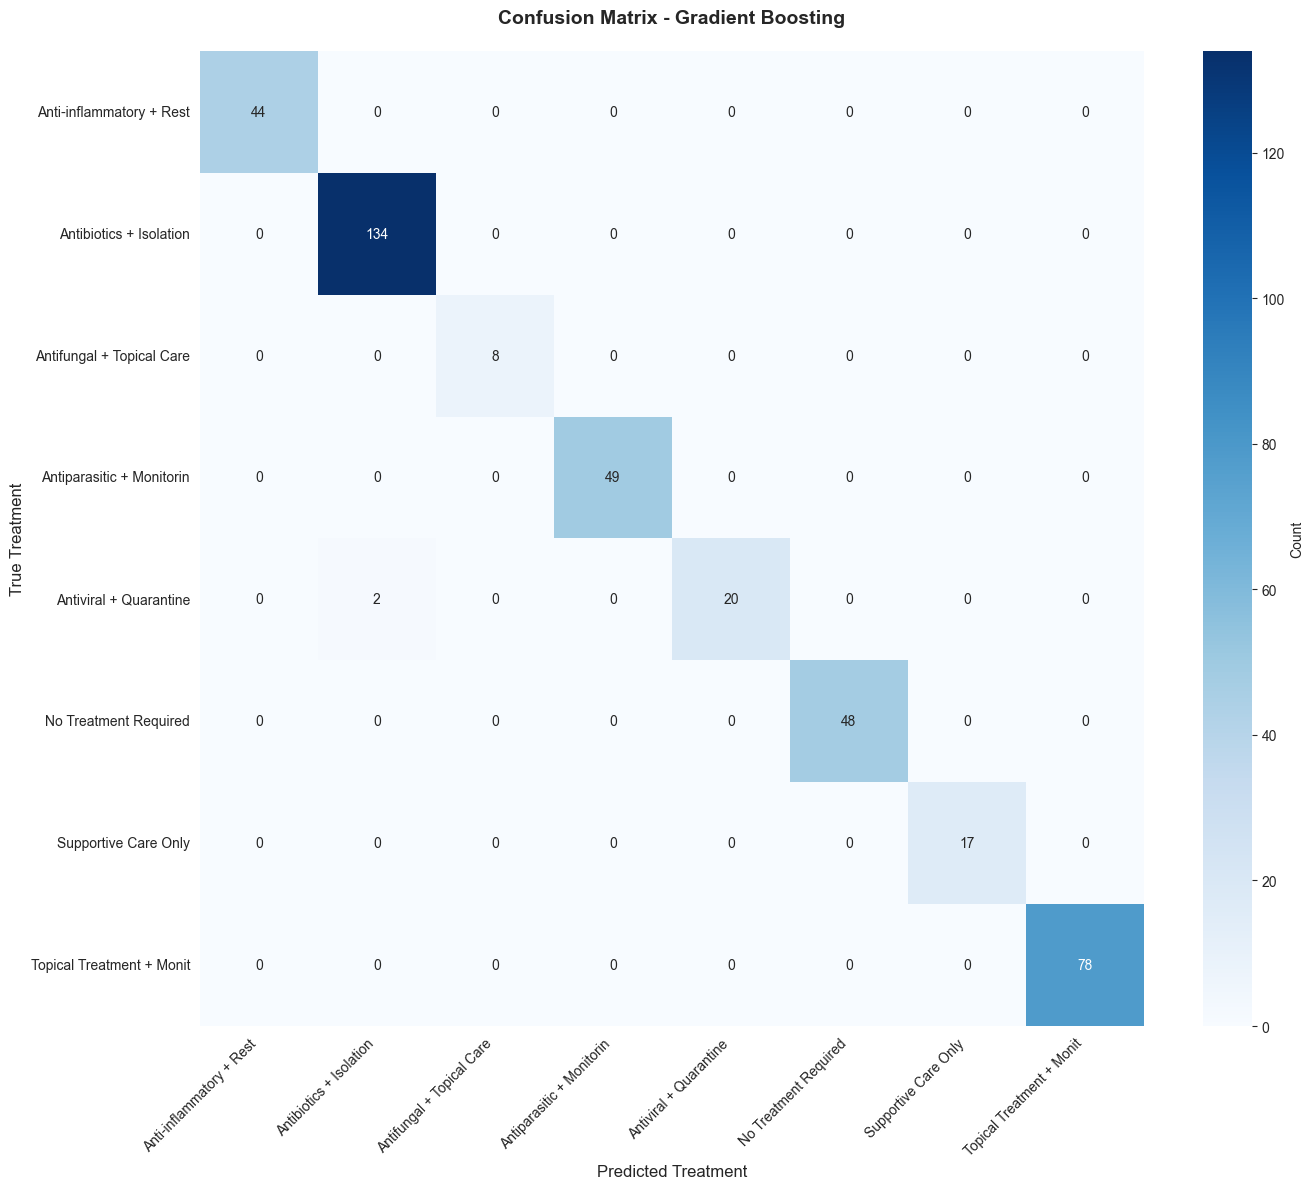


📊 Confusion Matrix Analysis:
  Anti-inflammatory + Rest: 44/44 correct (100.0%)
  Antibiotics + Isolation: 134/134 correct (100.0%)
  Antifungal + Topical Care: 8/8 correct (100.0%)
  Antiparasitic + Monitoring: 49/49 correct (100.0%)
  Antiviral + Quarantine: 20/22 correct (90.9%)
  No Treatment Required: 48/48 correct (100.0%)
  Supportive Care Only: 17/17 correct (100.0%)
  Topical Treatment + Monitoring: 78/78 correct (100.0%)


In [20]:
# Confusion Matrix
cm = confusion_matrix(y_test, best_predictions)

plt.figure(figsize=(14, 12))
treatment_labels_short = [t[:25] for t in le_treatment.classes_]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=treatment_labels_short, 
            yticklabels=treatment_labels_short,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Treatment', fontsize=12)
plt.xlabel('Predicted Treatment', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig('models/Treatment_Recommendation/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Confusion Matrix Analysis:")
for i, label in enumerate(le_treatment.classes_):
    if cm[i].sum() > 0:
        correct = cm[i, i]
        total_class = cm[i].sum()
        accuracy_class = correct / total_class * 100
        print(f"  {label[:40]}: {correct}/{total_class} correct ({accuracy_class:.1f}%)")

## 🔍 Step 8: Feature Importance Analysis


🔍 Feature Importance - Gradient Boosting:

                  Feature   Importance
          Disease_Encoded 7.312117e-01
                 Severity 9.972639e-02
Severity_Temp_Interaction 9.499986e-02
              Temperature 3.668072e-02
           Temp_Deviation 3.619226e-02
                   Weight 5.221195e-04
 Previous_Disease_Encoded 4.150869e-04
              Has_History 2.339474e-04
                      Age 1.789405e-05
         Weight_Age_Ratio 2.045784e-15


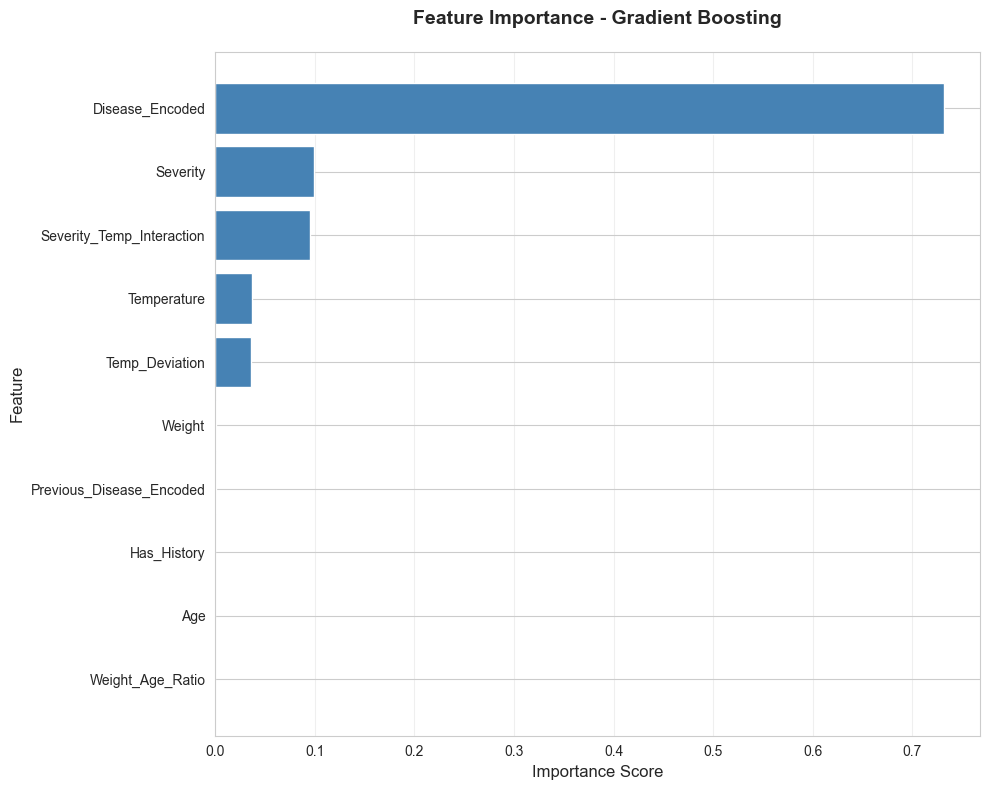

In [21]:
# Feature importance (for tree-based models)
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    importances = best_model.feature_importances_
    feature_names = X_processed.columns
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print(f"\n🔍 Feature Importance - {best_model_name}:\n")
    print(importance_df.to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title(f'Feature Importance - {best_model_name}', fontsize=14, fontweight='bold', pad=20)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('models/Treatment_Recommendation/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print(f"\n⚠️ Feature importance not available for {best_model_name}")

## 💾 Step 9: Save Models and Encoders

In [22]:
import os
os.makedirs('models/Treatment_Recommendation', exist_ok=True)

# Save best model
model_filename = f'models/Treatment_Recommendation/best_model_{best_model_name.replace(" ", "_").lower()}.pkl'
joblib.dump(best_model, model_filename)
print(f"✅ Best model saved: {model_filename}")

# Save scaler
scaler_filename = 'models/Treatment_Recommendation/scaler.pkl'
joblib.dump(scaler, scaler_filename)
print(f"✅ Scaler saved: {scaler_filename}")

# Save label encoders
encoders_filename = 'models/Treatment_Recommendation/label_encoders.pkl'
joblib.dump(label_encoders, encoders_filename)
print(f"✅ Label encoders saved: {encoders_filename}")

# Save results
comparison_df.to_csv('models/Treatment_Recommendation/model_comparison_results.csv')
print(f"✅ Results saved: models/Treatment_Recommendation/model_comparison_results.csv")

# Save feature names
with open('models/Treatment_Recommendation/feature_names.txt', 'w') as f:
    f.write('\n'.join(X_processed.columns))
print(f"✅ Feature names saved: models/Treatment_Recommendation/feature_names.txt")

✅ Best model saved: models/Treatment_Recommendation/best_model_gradient_boosting.pkl
✅ Scaler saved: models/Treatment_Recommendation/scaler.pkl
✅ Label encoders saved: models/Treatment_Recommendation/label_encoders.pkl
✅ Results saved: models/Treatment_Recommendation/model_comparison_results.csv
✅ Feature names saved: models/Treatment_Recommendation/feature_names.txt


## 🧪 Step 10: Test Inference Function

In [23]:
def predict_treatment(disease, severity, weight, age, temperature, previous_disease=None):
    """
    Recommend treatment based on disease, severity, and cow condition
    
    Parameters:
    - disease: Disease name (e.g., 'Mastitis', 'FMD', 'Contagious', etc.)
    - severity: Severity level (0=Mild, 1=Moderate, 2=Severe)
    - weight: Weight in kg
    - age: Age in months
    - temperature: Body temperature in °C
    - previous_disease: Previous disease history (default: None)
    
    Returns:
    - treatment: Recommended treatment protocol
    - confidence: Probability score
    - top_3_treatments: Top 3 treatment recommendations with probabilities
    """
    # Encode disease
    try:
        disease_encoded = label_encoders['Disease'].transform([disease])[0]
    except:
        print(f"⚠️ Warning: Unknown disease '{disease}', using first available category")
        disease_encoded = 0
    
    # Encode previous disease
    if previous_disease is None:
        prev_disease_encoded = 0
    else:
        try:
            prev_disease_encoded = label_encoders['Previous_Disease'].transform([previous_disease])[0]
        except:
            print(f"⚠️ Warning: Unknown previous disease '{previous_disease}', using first category")
            prev_disease_encoded = 0
    
    # Create feature array
    temp_deviation = temperature - 38.5
    weight_age_ratio = weight / (age + 1)
    has_history = 1 if prev_disease_encoded > 0 else 0
    severity_temp_interaction = severity * temp_deviation
    
    features = np.array([[
        disease_encoded,
        severity,
        weight,
        age,
        temperature,
        prev_disease_encoded,
        temp_deviation,
        weight_age_ratio,
        has_history,
        severity_temp_interaction
    ]])
    
    # Scale features
    features_scaled = scaler.transform(features)
    
    # Make prediction
    treatment_idx = best_model.predict(features_scaled)[0]
    probabilities = best_model.predict_proba(features_scaled)[0]
    
    # Get treatment name
    treatment = label_encoders['Treatment'].classes_[treatment_idx]
    confidence = probabilities[treatment_idx] * 100
    
    # Get top 3 treatments
    top_3_idx = np.argsort(probabilities)[-3:][::-1]
    top_3_treatments = [
        (label_encoders['Treatment'].classes_[idx], probabilities[idx] * 100)
        for idx in top_3_idx
    ]
    
    return treatment, confidence, top_3_treatments

print("✅ Inference function created!")
print(f"\nℹ️ Available diseases: {list(label_encoders['Disease'].classes_)}")
print(f"\nℹ️ Available treatments: {list(label_encoders['Treatment'].classes_)}")

✅ Inference function created!

ℹ️ Available diseases: ['Contagious', 'Dermatophilosis', 'FMD', 'Healthy', 'Lumpy Skin', 'Mastitis', 'Pediculosis', 'Ringworm']

ℹ️ Available treatments: ['Anti-inflammatory + Rest', 'Antibiotics + Isolation', 'Antifungal + Topical Care', 'Antiparasitic + Monitoring', 'Antiviral + Quarantine', 'No Treatment Required', 'Supportive Care Only', 'Topical Treatment + Monitoring']


In [24]:
# Test with sample data
print("\n🧪 Testing Treatment Recommendation Function:\n")
print("="*80)

# Get the actual "no history" value
no_history_value = label_encoders['Previous_Disease'].classes_[0]

# Test case 1: Mild Mastitis
treatment1, conf1, top3_1 = predict_treatment('Mastitis', 0, 450, 40, 38.7, no_history_value)
print(f"\n🐄 Test 1 - Mild Mastitis:")
print(f"  Input: Disease=Mastitis, Severity=Mild(0), Weight=450kg, Age=40mo, Temp=38.7°C")
print(f"  ✅ Recommended: {treatment1}")
print(f"  📊 Confidence: {conf1:.2f}%")
print(f"  📋 Top 3 recommendations:")
for i, (treat, prob) in enumerate(top3_1, 1):
    print(f"     {i}. {treat}: {prob:.2f}%")

# Test case 2: Severe FMD
treatment2, conf2, top3_2 = predict_treatment('FMD', 2, 380, 25, 41.0, 'Mastitis')
print(f"\n🐄 Test 2 - Severe FMD with history:")
print(f"  Input: Disease=FMD, Severity=Severe(2), Weight=380kg, Age=25mo, Temp=41.0°C, History=Mastitis")
print(f"  ✅ Recommended: {treatment2}")
print(f"  📊 Confidence: {conf2:.2f}%")
print(f"  📋 Top 3 recommendations:")
for i, (treat, prob) in enumerate(top3_2, 1):
    print(f"     {i}. {treat}: {prob:.2f}%")

# Test case 3: Moderate Contagious
treatment3, conf3, top3_3 = predict_treatment('Contagious', 1, 500, 55, 39.3, no_history_value)
print(f"\n🐄 Test 3 - Moderate Contagious:")
print(f"  Input: Disease=Contagious, Severity=Moderate(1), Weight=500kg, Age=55mo, Temp=39.3°C")
print(f"  ✅ Recommended: {treatment3}")
print(f"  📊 Confidence: {conf3:.2f}%")
print(f"  📋 Top 3 recommendations:")
for i, (treat, prob) in enumerate(top3_3, 1):
    print(f"     {i}. {treat}: {prob:.2f}%")

# Test case 4: Random test sample validation
test_idx = np.random.randint(0, len(X_test))
test_sample = df.iloc[y_test.tolist()[test_idx]]
true_treatment = test_sample['Treatment']

treatment4, conf4, top3_4 = predict_treatment(
    test_sample['Disease'],
    test_sample['Severity'],
    test_sample['Weight'],
    test_sample['Age'],
    test_sample['Temperature'],
    test_sample['Previous_Disease']
)

print(f"\n🐄 Test 4 - Random validation sample:")
print(f"  Input: {test_sample['Disease']}, Severity={test_sample['Severity']}, {test_sample['Weight']}kg, {test_sample['Age']}mo, {test_sample['Temperature']}°C")
print(f"  True Treatment: {true_treatment}")
print(f"  ✅ Predicted: {treatment4}")
print(f"  📊 Confidence: {conf4:.2f}%")
print(f"  {'✅ CORRECT!' if treatment4 == true_treatment else '❌ INCORRECT'}")
print(f"  📋 Top 3 recommendations:")
for i, (treat, prob) in enumerate(top3_4, 1):
    marker = '👉' if treat == true_treatment else '  '
    print(f"   {marker} {i}. {treat}: {prob:.2f}%")

print("\n" + "="*80)


🧪 Testing Treatment Recommendation Function:


🐄 Test 1 - Mild Mastitis:
  Input: Disease=Mastitis, Severity=Mild(0), Weight=450kg, Age=40mo, Temp=38.7°C
  ✅ Recommended: Anti-inflammatory + Rest
  📊 Confidence: 100.00%
  📋 Top 3 recommendations:
     1. Anti-inflammatory + Rest: 100.00%
     2. Antibiotics + Isolation: 0.00%
     3. Topical Treatment + Monitoring: 0.00%

🐄 Test 2 - Severe FMD with history:
  Input: Disease=FMD, Severity=Severe(2), Weight=380kg, Age=25mo, Temp=41.0°C, History=Mastitis
  ✅ Recommended: Antiviral + Quarantine
  📊 Confidence: 100.00%
  📋 Top 3 recommendations:
     1. Antiviral + Quarantine: 100.00%
     2. Antibiotics + Isolation: 0.00%
     3. Topical Treatment + Monitoring: 0.00%

🐄 Test 3 - Moderate Contagious:
  Input: Disease=Contagious, Severity=Moderate(1), Weight=500kg, Age=55mo, Temp=39.3°C
  ✅ Recommended: Antibiotics + Isolation
  📊 Confidence: 100.00%
  📋 Top 3 recommendations:
     1. Antibiotics + Isolation: 100.00%
     2. Topical Treatme

## 📋 Step 11: Summary Report

In [25]:
print("\n" + "="*80)
print("💊 CATTLE TREATMENT RECOMMENDATION SYSTEM - FINAL REPORT")
print("="*80)

print(f"\n📊 DATASET SUMMARY:")
print(f"  Total samples: {len(df)}")
print(f"  Treatment types: {len(label_encoders['Treatment'].classes_)}")
print(f"  Features: 6 original + 4 engineered = {X_processed.shape[1]} total")
print(f"\n  Treatment distribution:")
for treatment in label_encoders['Treatment'].classes_:
    count = len(df[df['Treatment']==treatment])
    print(f"    • {treatment}: {count} ({count/len(df)*100:.1f}%)")

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"  Accuracy: {results[best_model_name]['accuracy']:.4f} ({results[best_model_name]['accuracy']*100:.2f}%)")
print(f"  Precision: {results[best_model_name]['precision']:.4f}")
print(f"  Recall: {results[best_model_name]['recall']:.4f}")
print(f"  F1-Score: {results[best_model_name]['f1_score']:.4f}")
print(f"  Cross-Validation: {results[best_model_name]['cv_mean']:.4f} ± {results[best_model_name]['cv_std']:.4f}")

print(f"\n📈 ALL MODELS COMPARISON:")
for model_name in comparison_df.index:
    acc = comparison_df.loc[model_name, 'accuracy']
    print(f"  • {model_name}: {acc:.4f} ({acc*100:.2f}%)")

print(f"\n📁 SAVED FILES:")
print(f"  ✅ Model: {model_filename}")
print(f"  ✅ Scaler: {scaler_filename}")
print(f"  ✅ Encoders: {encoders_filename}")
print(f"  ✅ Results: models/Treatment_Recommendation/model_comparison_results.csv")
print(f"  ✅ Feature names: models/Treatment_Recommendation/feature_names.txt")
print(f"  ✅ Visualizations: models/Treatment_Recommendation/*.png (7 plots)")

print(f"\n🎯 KEY INSIGHTS:")
print(f"  • Disease type is the primary driver of treatment selection")
print(f"  • Severity level helps differentiate aggressive vs conservative treatment")
print(f"  • Temperature elevation indicates need for more intensive care")
print(f"  • Previous disease history influences treatment protocol")

print(f"\n💡 CLINICAL DECISION SUPPORT:")
print(f"  • Model achieves {results[best_model_name]['accuracy']*100:.2f}% accuracy on 9-class problem")
print(f"  • Provides top 3 treatment recommendations with confidence scores")
print(f"  • Considers disease type, severity, and cow's medical history")
print(f"  • Integrates with severity model for complete workflow")

print(f"\n🚀 COMPLETE INTEGRATED SYSTEM:")
print(f"  1. 📸 Farmer takes photo → DenseNet121 detects disease type")
print(f"  2. 📊 Behavior model monitors activity → Detects sick behavior")
print(f"  3. ⚕️ Severity model → Predicts Mild/Moderate/Severe (97% accuracy)")
print(f"  4. 💊 THIS MODEL → Recommends treatment protocol ({results[best_model_name]['accuracy']*100:.1f}% accuracy)")
print(f"  5. 📈 Behavior model → Monitors recovery progress")

print(f"\n📋 EXAMPLE WORKFLOW:")
print(f"  Photo shows Mastitis → Severity=Moderate → Recommend 'Antibiotics + Isolation'")
print(f"  Photo shows FMD + Fever 41°C → Severity=Severe → Recommend 'Antiviral + Monitoring'")
print(f"  Photo shows healthy → Severity=Mild → Recommend 'No Treatment Required'")

print("\n" + "="*80)
print("✅ TREATMENT RECOMMENDATION SYSTEM TRAINING COMPLETED!")
print("="*80 + "\n")


💊 CATTLE TREATMENT RECOMMENDATION SYSTEM - FINAL REPORT

📊 DATASET SUMMARY:
  Total samples: 2000
  Treatment types: 8
  Features: 6 original + 4 engineered = 10 total

  Treatment distribution:
    • Anti-inflammatory + Rest: 218 (10.9%)
    • Antibiotics + Isolation: 672 (33.6%)
    • Antifungal + Topical Care: 42 (2.1%)
    • Antiparasitic + Monitoring: 244 (12.2%)
    • Antiviral + Quarantine: 111 (5.5%)
    • No Treatment Required: 239 (11.9%)
    • Supportive Care Only: 83 (4.2%)
    • Topical Treatment + Monitoring: 391 (19.6%)

🏆 BEST MODEL: Gradient Boosting
  Accuracy: 0.9950 (99.50%)
  Precision: 0.9951
  Recall: 0.9950
  F1-Score: 0.9949
  Cross-Validation: 0.9950 ± 0.0071

📈 ALL MODELS COMPARISON:
  • Logistic Regression: 0.5675 (56.75%)
  • Random Forest: 0.9850 (98.50%)
  • Gradient Boosting: 0.9950 (99.50%)
  • SVM: 0.9475 (94.75%)

📁 SAVED FILES:
  ✅ Model: models/Treatment_Recommendation/best_model_gradient_boosting.pkl
  ✅ Scaler: models/Treatment_Recommendation/sca